In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import re

# Algoritmos de recomendación de películas

En el siguiente notebook se desarrollarán dos algoritmos sencillos basados en álgebra y matemática sencilla para determinar películas recomendadas para un usuario.

## Preparación de los datos

In [3]:
#Leemos los datos
movies = pd.read_csv("mymoviedb.csv", lineterminator='\n')

In [4]:
movies = movies[['Release_Date', 'Title', 'Overview','Original_Language', 'Genre']]
movies

,Release_Date,Title,Overview,Original_Language,Genre
0,2021-12-15,Spider-Man: No Way Home,Peter Parker is unmasked and no longer able to...,en,"Action, Adventure, Science Fiction"
1,2022-03-01,The Batman,"In his second year of fighting crime, Batman u...",en,"Crime, Mystery, Thriller"
2,2022-02-25,No Exit,Stranded at a rest stop in the mountains durin...,en,Thriller
3,2021-11-24,Encanto,"The tale of an extraordinary family, the Madri...",en,"Animation, Comedy, Family, Fantasy"
4,2021-12-22,The King's Man,As a collection of history's worst tyrants and...,en,"Action, Adventure, Thriller, War"
...,...,...,...,...,...
9822,1973-10-15,Badlands,A dramatization of the Starkweather-Fugate kil...,en,"Drama, Crime"
9823,2020-10-01,Violent Delights,A female vampire falls in love with a man she ...,es,Horror
9824,2016-05-06,The Offering,When young and successful reporter Jamie finds...,en,"Mystery, Thriller, Horror"
9825,2021-03-31,The United States vs. Billie Holiday,Billie Holiday spent much of her career being ...,en,"Music, Drama, History"


In [5]:
#Transformo la fecha del formato yyyy/mm/dd al formato yyyy
for row in range(9827):
    movies["Release_Date"][row] = int(movies["Release_Date"][row][0:4])

<AxesSubplot:xlabel='Release_Date', ylabel='Count'>

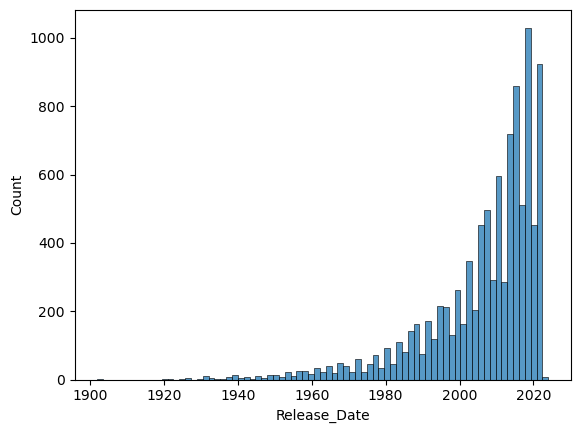

In [6]:
#Observamos la distribución de los años
sns.histplot(movies["Release_Date"])

In [7]:
#Obtengo los cuartiles de la variable "Release_Data" 
quantiles = [0.25, 0.5, 0.75]
result = movies["Release_Date"].quantile(quantiles)
print(result)

0.25    2000.0
0.50    2011.0
0.75    2017.0
Name: Release_Date, dtype: object


In [8]:
# Se dividirán las películas en 5 categorías diferentes segun sus cuartiles
# Posteriores al 2017, entre 2011 y 2017, entre 2011 y 2000 y anteriores al 2000.

bins = [1900,2000,2011,2017,2022]
labels = [0,1,2,4]
movies["Release_Date"] = pd.cut(movies["Release_Date"], bins=bins, labels=labels, include_lowest=True)
one_hot_encoded_date = pd.get_dummies(movies['Release_Date'], prefix='RD')
movies = pd.concat([movies, one_hot_encoded_date], axis=1)

In [9]:
# Se dividirán las películas en 5 categorías de idiomas -Inglés, japonés español, francés y otros- 
movies['Original_Language'] = movies['Original_Language'].astype(str)
movies.loc[~movies["Original_Language"].isin(["en", "ja", "es", "fr"]), "Original_Language"] = "otro"
movies['Original_Language'] = movies['Original_Language'].astype("category")

<AxesSubplot:xlabel='Original_Language', ylabel='Count'>

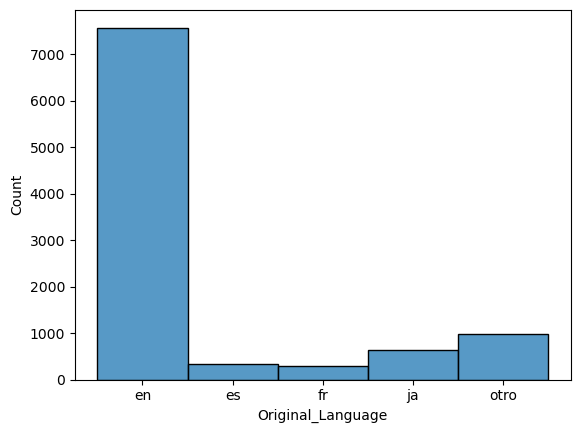

In [10]:
sns.histplot(movies["Original_Language"])

In [11]:
#Transformo el lenguaje a "one hot encoding"
one_hot_encoded_lan = pd.get_dummies(movies['Original_Language'], prefix='lan')
movies = pd.concat([movies, one_hot_encoded_lan], axis=1)

In [12]:
#Con expresiones regulares hallo las diferentes categorías de la columna "Genre"

patron = r'\b[^,]+(?=,|$)'
list_of_genres = []
for row in range(9827):
    texto = movies["Genre"][row]
    genres = re.findall(patron,texto)
    for y in genres:
        if y not in list_of_genres:
            list_of_genres.append(y)

In [13]:
new_columns = {}
for genre in list_of_genres:
    new_columns[genre] = [0]*9827

In [14]:
movies = movies.assign(**new_columns)

In [15]:
#Realizo one hot encoding con cada uno de los géneros extraidos anteriormente
for genre in list_of_genres:
    for index, row in movies.iterrows():
        if genre in row["Genre"]:
            movies.at[index, genre] = 1

In [16]:
movies_hot_encoded = movies[[
       'RD_0', 'RD_1', 'RD_2', 'RD_4','lan_en', 'lan_es', 'lan_fr', 'lan_ja', 'lan_otro', 'Action','Adventure', 'Science Fiction', 'Crime', 'Mystery', 'Thriller','Animation', 'Comedy', 'Family', 'Fantasy', 'War', 'Horror', 'Drama',
       'Music', 'Romance', 'Western', 'History', 'TV Movie', 'Documentary']]

# Algorítmo 1

### Se realiza un algoritmo sencillo basado en el álgebra lineal

In [17]:
usuario_1 = {500:4, 504:2.5, 524:5, 541:2.4 ,584:2} 
usuario_2 = {445:4, 454:2.5, 455:5, 461:2.4 ,625:3}  #Iron Man, La liga de la justicia,Interestellar, los increíbles, Star Wars

In [18]:
def recomendar(preferencias):
    valoracion_usuario =  [preferencias[i] for i in list(preferencias.keys())] 
    valoracion_usuario= np.array(valoracion_usuario)
    movies_usuario = movies.iloc[list(preferencias.keys())] #Se obtienen las películas que le gustaron al usuario
    matriz_usuario = movies_usuario[[
                                       'RD_0', 'RD_1', 'RD_2', 'RD_4','lan_en', 'lan_es', 'lan_fr', 'lan_ja', 'lan_otro', 'Action','Adventure', 'Science Fiction', 'Crime', 'Mystery', 'Thriller','Animation', 'Comedy', 'Family', 'Fantasy', 'War', 'Horror', 'Drama',
                                        'Music', 'Romance', 'Western', 'History', 'TV Movie', 'Documentary'
                                                                                                                ]]
    vector_peso_usuario = np.dot(valoracion_usuario,matriz_usuario) #Se obtiene un vector de peso de cada usuario
    peso_candidatas = np.dot( movies_hot_encoded, vector_peso_usuario)
    peso_candidatas = list(peso_candidatas) #Se calcula el peso de las películas
    indices_valores_maximos = np.argsort(peso_candidatas)[-5:] #Se obtienen las 5 películas con mejor peso
    return movies.iloc[list(indices_valores_maximos)]
    
    

## Ejemplos
#### Se presentan 2 ejemplos de usuarios con distintas preferencias

In [19]:
a = recomendar(usuario_1)
b = recomendar(usuario_2)

In [20]:
movies.loc[list(usuario_1.keys())]["Title"]

500                         Toy Story 3
504                               Ponyo
524          Ice Age: Continental Drift
541    Dragon Ball Z: The Tree of Might
584                          Madagascar
Name: Title, dtype: object

In [21]:
def show_favorites_and_recommended(preferencias):
    print("Películas que vió y puntuó el usuario:")
    print(movies.loc[list(preferencias.keys())]["Title"])
    print("\n \n")
    print("Películas que se le recomiendan al usuario:") 
    print(recomendar(preferencias)["Title"])
    

In [22]:
show_favorites_and_recommended(usuario_1)

Películas que vió y puntuó el usuario:
500                         Toy Story 3
504                               Ponyo
524          Ice Age: Continental Drift
541    Dragon Ball Z: The Tree of Might
584                          Madagascar
Name: Title, dtype: object

 

Películas que se le recomiendan al usuario:
4748                Happily N'Ever After
655                  Shrek Forever After
1815    Sinbad: Legend of the Seven Seas
4579           Jimmy Neutron: Boy Genius
4239                 Yu-Gi-Oh! The Movie
Name: Title, dtype: object


# Algoritmo 2: recomendación por similitud de cosenos

Se transforma cada película en un vector y luego se calcula el coseno entre la película elegida y todas las demás. La película que tenga el coseno mas cercano a 1 (es decír un ángulo menor si se quiere pensar de esta manera) será recomendada por el algorítmo. Los cosenos se pueden calcular con la siguiente fórmula, pero en este caso utilizaré "cosine_similarity" incluido en la librería Scikit Learn.

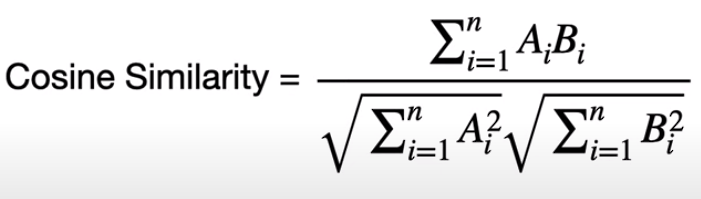

In [23]:
from sklearn.metrics.pairwise import cosine_similarity

In [24]:
#Utilizaremos los datos calculados antes "movies_hot_encoded"
#El usuario en este caso elegirá una película, supongamos que elije la 1 "Batman"
movie_user = movies_hot_encoded.loc[1] #Movie_user == Batman
movie_user = movie_user.to_numpy().reshape(1, -1) #Convierto la película en un array 
similarity_scores = cosine_similarity(movies_hot_encoded, movie_user) #Aplico el algorítmo mediante scikit-learn

In [25]:
sorted_indices = np.argsort(similarity_scores.flatten())[::-1][1:7]
sorted_indices = np.delete(sorted_indices, np.where(sorted_indices == 1))
# Obtener los valores de similitud correspondientes a los 5 índices
top_5_similarities = similarity_scores[sorted_indices]

# Obtengo las 5 filas con las similitudes mas cercanas a 1
top_5_df = pd.DataFrame({'Similarity': top_5_similarities.flatten()}, index=sorted_indices)

In [26]:
peliculas_similares = movies.iloc[top_5_df["Similarity"].index] #Extraigo las películas del data frame original
peliculas_similares

,Release_Date,Title,Overview,Original_Language,Genre,RD_0,RD_1,RD_2,RD_4,lan_en,...,Fantasy,War,Horror,Drama,Music,Romance,Western,History,TV Movie,Documentary
7898,4,Wander,After getting hired to probe a suspicious deat...,en,"Thriller, Crime, Mystery",0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
6154,4,The Darker the Lake,"When strange, supernatural murders suddenly be...",en,"Crime, Thriller, Mystery",0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4768,4,The Dry,Aaron Falk returns to his drought-stricken hom...,en,"Crime, Thriller, Mystery",0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
6863,4,Hold the Dark,"In the grim Alaskan winter, a naturalist hunts...",en,"Thriller, Mystery, Crime",0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
558,4,Beckett,An American tourist in Greece finds himself on...,en,"Crime, Mystery, Thriller",0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [47]:
def recommend_movies(index_movie):
    """Recomienda películas similares a la película seleccionada por su índice"""
    movie_user = movies_hot_encoded.loc[index_movie]
    print("Película elegida :", movies.loc[index_movie]["Title"])
    movie_user = movie_user.to_numpy().reshape(1, -1) 
    similarity_scores = cosine_similarity(movies_hot_encoded, movie_user) 
    sorted_indices = np.argsort(similarity_scores.flatten())[::-1][1:7]
    sorted_indices = np.delete(sorted_indices, np.where(sorted_indices == index_movie))
    top_5_similarities = similarity_scores[sorted_indices]
    top_5_df = pd.DataFrame({'Similarity': top_5_similarities.flatten()}, index=sorted_indices)
    peliculas_similares = movies.iloc[top_5_df["Similarity"].index] #Extraigo las películas del data frame original
    print("Recomendaciones: "," \n", peliculas_similares["Title"])

### Ejemplos: El usuario elije la película 317 "Cars"

In [48]:
#El usuario es un niño y eligió "Cars 2"
recommend_movies(317)

Película elegida : Cars 2
Recomendaciones:   
 3044    Mickey, Donald, Goofy: The Three Musketeers
4394                                  Open Season 2
440                  Ice Age: Dawn of the Dinosaurs
5972                                  Open Season 3
2640                                 Curious George
Name: Title, dtype: object


El usuario eligió la película animada "Cars 2" y el algoritmo le recomendó 5 películas similares todas de dibujos animados para niños.

### Ejemplos: El usuario elije la película 935 "Django Unchained"

In [49]:
#Al nuevo usuario le gusta Quentin Tarantino y elije la película 935 "Django Unchained"
recommend_movies(935)

Película elegida : Django Unchained
Recomendaciones:   
 8775             Frontera
5196       Jane Got a Gun
4834       The Dressmaker
2705    The Hateful Eight
3855             Hostiles
Name: Title, dtype: object


Al usuario le encanta Tarantino y eligió ver The Hateful Eight

### Ejemplos: El usuario elije la película 461 "Interestellar"

In [50]:
# El útlimo usuario es un apasionado del cine sci-fi y eligió "Interestellar"
recommend_movies(461)

Película elegida : Interstellar
Recomendaciones:   
 6727          Midnight Special
931                The Martian
4298      The Space Between Us
168     Spider-Man: Homecoming
4750                    Stasis
Name: Title, dtype: object


Al último usuario muy probablemente le guste "Midnight Special"

In [51]:
def buscar_indice(palabra_clave):
    """Esta función te permite buscar el índice de una película en el dataframe movies"""
    return movies[movies['Title'].str.contains(palabra_clave, case=False)]

In [52]:
recommend_movies(1423)

Película elegida : The Terminator
Recomendaciones:   
 8143         Red Planet
2377            RoboCop
1865             Aliens
2845    The Running Man
2352           Godzilla
Name: Title, dtype: object


In [53]:
recommend_movies(1810)

Película elegida : Taxi Driver
Recomendaciones:   
 8506             Dancer in the Dark
3186                         Casino
8674            Requiem for a Dream
2891                    Stand by Me
8615               Midnight Express
2384    Once Upon a Time in America
Name: Title, dtype: object
